In [14]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("../data/insurance.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 50 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      1000098 non-null  object 
 9   AccountType               1000098 non-null  object 
 10  MaritalStatus             1000098 non-null  object 
 11  Gender                    1000098 non-null  object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Drop constant columns
drop_cols = ['Language', 'Country', 'ItemType', 'StatutoryClass', 'StatutoryRiskType']
df.drop(columns=drop_cols, inplace=True)

# Label Encoding for binary columns
label_cols = ['Gender', 'AlarmImmobiliser', 'TrackingDevice', 'WrittenOff',
              'Rebuilt', 'Converted', 'TermFrequency']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Optional: Label encode TransactionMonth (or extract year/month separately)
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['Month'] = df['TransactionMonth'].dt.month
df['Year'] = df['TransactionMonth'].dt.year
df.drop(columns=['TransactionMonth'], inplace=True)

# Optional: Convert VehicleIntroDate to month and year
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')
df['VehicleIntroYear'] = df['VehicleIntroDate'].dt.year
df['VehicleIntroMonth'] = df['VehicleIntroDate'].dt.month
df.drop(columns=['VehicleIntroDate'], inplace=True)

# One-hot encoding
one_hot_cols = ['Citizenship', 'LegalType', 'Title', 'Bank', 'AccountType', 'MaritalStatus',
                'Province', 'MainCrestaZone', 'SubCrestaZone', 'VehicleType', 'make',
                'bodytype', 'NewVehicle', 'ExcessSelected', 'CoverCategory', 'CoverType',
                'CoverGroup', 'Section', 'Product']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


In [24]:
# Convert mmcode to float
df['mmcode'] = pd.to_numeric(df['mmcode'], errors='coerce')
print(df['mmcode'].dtype)
df['mmcode'].isna().sum()  # See how many were invalid

float64


552

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Columns: 269 entries, UnderwrittenCoverID to Product_Standalone Passenger Liability
dtypes: bool(242), float64(11), int32(4), int64(11), object(1)
memory usage: 421.6+ MB


In [26]:
df_claims_clean = df[df['TotalClaims'] > 0].copy()

# Drop columns that are irrelevant or already processed(PolicyID, UnderwrittenCoverID are identifiers)
drop_ids_and_processed = ['PolicyID', 'UnderwrittenCoverID']
df_claims_clean.drop(columns=[col for col in drop_ids_and_processed if col in df_claims_clean.columns], inplace=True)

df_claims_clean = df_claims_clean.dropna(thresh=len(df_claims_clean) * 0.9, axis=1)
df_claims_clean = df_claims_clean.dropna()

if 'RegistrationYear' in df_claims_clean.columns:
    df_claims_clean['VehicleAge'] = 2025 - df_claims_clean['RegistrationYear']
    df_claims_clean.drop(columns=['RegistrationYear'], inplace=True) # Drop original year as 'VehicleAge' replaces it

# if any 'object' or 'category' dtypes still exist that need encoding.
remaining_categorical_cols = df_claims_clean.select_dtypes(include=['object', 'category']).columns

if len(remaining_categorical_cols) > 0:
    print(f"Warning: Found remaining categorical columns: {remaining_categorical_cols}. Applying one-hot encoding again.")
    df_claims_clean = pd.get_dummies(df_claims_clean, columns=remaining_categorical_cols, drop_first=True)
else:
    print("No remaining object/category columns found. Data is numeric or already encoded.")

# Define features (X) and target (y)
X_claim_severity = df_claims_clean.drop('TotalClaims', axis=1)
y_claim_severity = df_claims_clean['TotalClaims']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_claim_severity, y_claim_severity, test_size=0.2, random_state=42
)

print("\nShape of training data for Claim Severity:")
print(f"X_train_sev: {X_train_sev.shape}")
print(f"y_train_sev: {y_train_sev.shape}")
print(f"X_test_sev: {X_test_sev.shape}")
print(f"y_test_sev: {y_test_sev.shape}")


Shape of training data for Claim Severity:
X_train_sev: (2220, 403)
y_train_sev: (2220,)
X_test_sev: (555, 403)
y_test_sev: (555,)


### Linear Regression

Linear Regression Performance (Claim Severity):
 RMSE: 34656.14
 R² Score: 0.1566


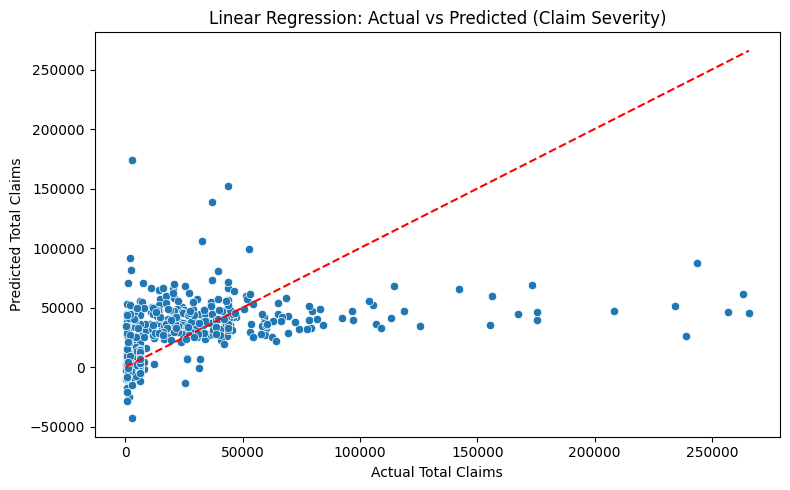

In [27]:
lr_model = LinearRegression()
lr_model.fit(X_train_sev, y_train_sev)

# Predict
y_pred_lr = lr_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test_sev, y_pred_lr))
r2_lr = r2_score(y_test_sev, y_pred_lr)

print(f"Linear Regression Performance (Claim Severity):")
print(f" RMSE: {rmse_lr:.2f}")
print(f" R² Score: {r2_lr:.4f}")

# Visualize
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_lr)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("Linear Regression: Actual vs Predicted (Claim Severity)")
# range of actual test values for the reference line
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

### Random Forest

Random Forest Performance (Claim Severity):
RMSE: 33593.65
R² Score: 0.2076


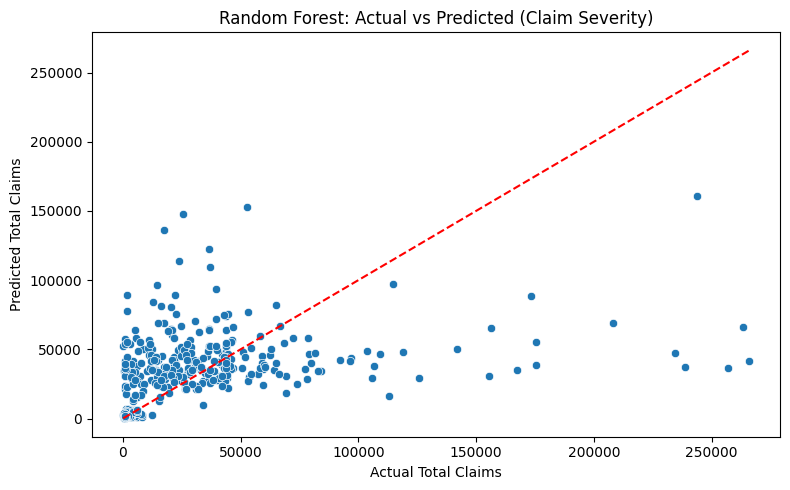

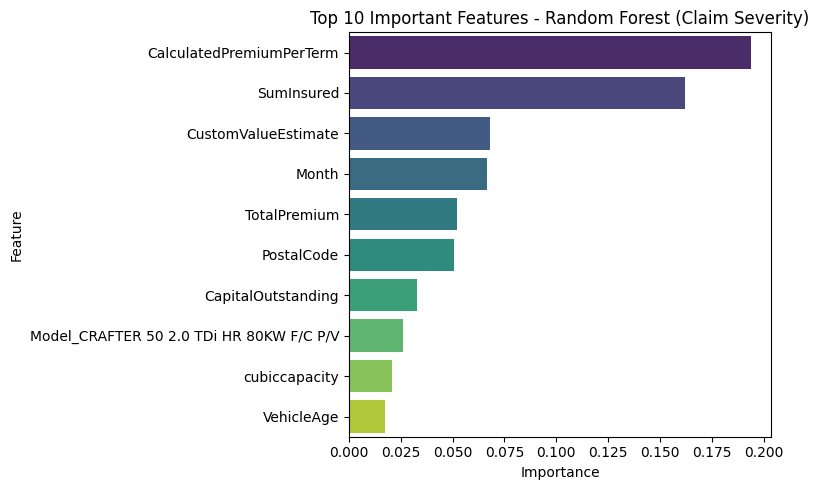

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_sev, y_train_sev)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation metrics
rf_rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_rf))
rf_r2 = r2_score(y_test_sev, y_pred_rf)

print(f"Random Forest Performance (Claim Severity):")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_rf)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("Random Forest: Actual vs Predicted (Claim Severity)")
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

# Feature Importances (Random Forest)
importances = rf_model.feature_importances_
feature_names = X_train_sev.columns # Use X_train_sev here
rf_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=rf_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Important Features - Random Forest (Claim Severity)")
plt.tight_layout()
plt.show()

### XGBoost

In [46]:
# !pip install xgboost

XGBoost Performance (Claim Severity):
 RMSE: 34678.30
 R² Score: 0.1556


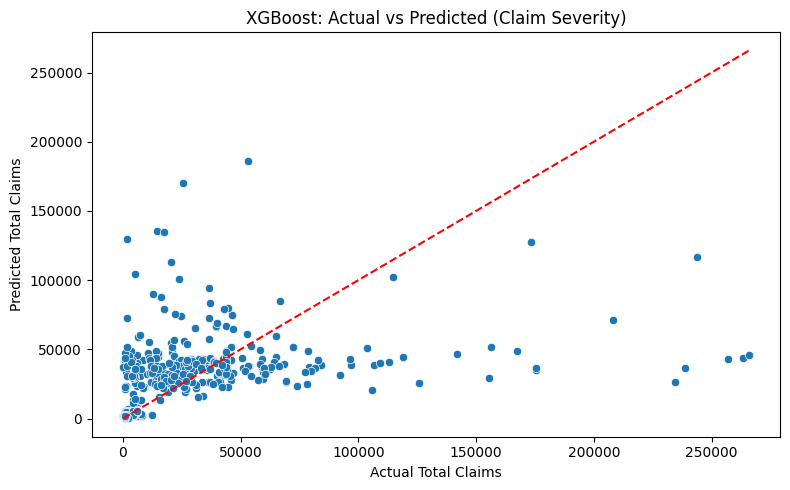

In [37]:
import xgboost as xgb

# Initialize and train model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_sev, y_train_sev)

# Predict
y_pred_xgb = xgb_model.predict(X_test_sev) # Changed variable name for clarity

# Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_xgb))
xgb_r2 = r2_score(y_test_sev, y_pred_xgb)

print(f"XGBoost Performance (Claim Severity):")
print(f" RMSE: {xgb_rmse:.2f}")
print(f" R² Score: {xgb_r2:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_sev, y=y_pred_xgb)
plt.xlabel("Actual Total Claims")
plt.ylabel("Predicted Total Claims")
plt.title("XGBoost: Actual vs Predicted (Claim Severity)")
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.tight_layout()
plt.show()

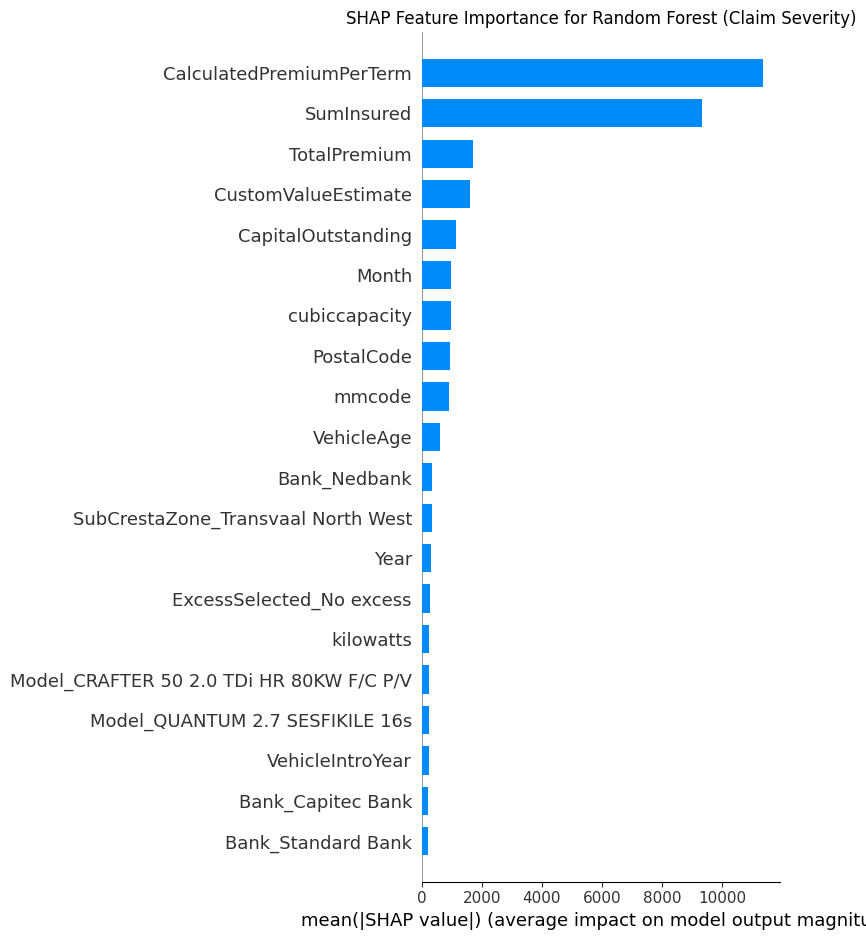


Top 10 Most Influential Features (Claim Severity):
                      feature  shap_abs_mean
17   CalculatedPremiumPerTerm   11351.334734
15                 SumInsured    9335.989601
18               TotalPremium    1713.549182
8         CustomValueEstimate    1605.936249
11         CapitalOutstanding    1144.271261
19                      Month     978.409527
5               cubiccapacity     972.462176
2                  PostalCode     943.869714
3                      mmcode     893.485733
264                VehicleAge     610.510097


In [43]:
import shap
best_severity_model = rf_model
best_severity_model_name = "Random Forest"
X_test_for_shap = X_test_sev # Use the test features for the best model

explainer = shap.TreeExplainer(best_severity_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

shap.summary_plot(shap_values, X_test_for_shap, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance for {best_severity_model_name} (Claim Severity)")
plt.tight_layout()
plt.show()

# Get top features for interpretation
shap_df = pd.DataFrame({
    'feature': X_test_for_shap.columns,
    'shap_abs_mean': np.abs(shap_values).mean(axis=0)
})
top_features = shap_df.sort_values(by='shap_abs_mean', ascending=False).head(10)
print("\nTop 10 Most Influential Features (Claim Severity):")
print(top_features)

Linear Regression Performance (Claim Severity):
 RMSE: 34656.14
 R² Score: 0.1566


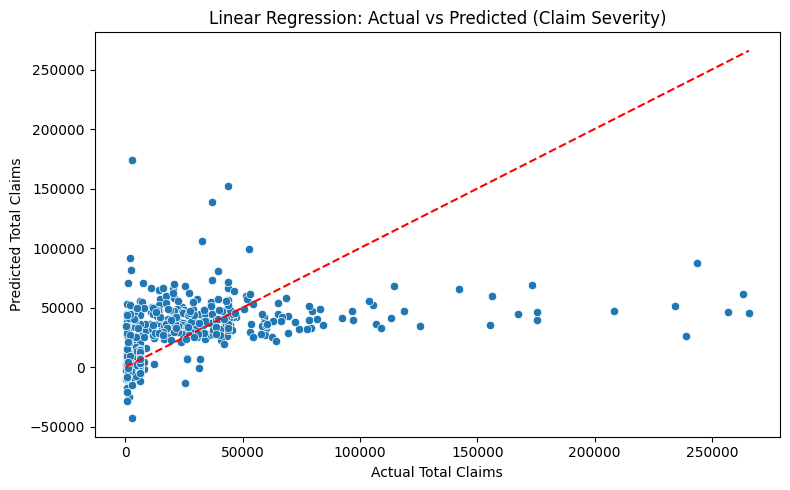

In [8]:

# lr_model = LinearRegression()
# lr_model.fit(X_train_sev, y_train_sev)

# # Predict
# y_pred_lr = lr_model.predict(X_test_sev) # Changed variable name for clarity

# # Evaluation
# rmse_lr = np.sqrt(mean_squared_error(y_test_sev, y_pred_lr))
# r2_lr = r2_score(y_test_sev, y_pred_lr)

# print(f"Linear Regression Performance (Claim Severity):")
# print(f" RMSE: {rmse_lr:.2f}")
# print(f" R² Score: {r2_lr:.4f}")

# # Visualize
# plt.figure(figsize=(8, 5))
# sns.scatterplot(x=y_test_sev, y=y_pred_lr)
# plt.xlabel("Actual Total Claims")
# plt.ylabel("Predicted Total Claims")
# plt.title("Linear Regression: Actual vs Predicted (Claim Severity)")
# # range of actual test values for the reference line
# plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
# plt.tight_layout()
# plt.show()

XGBoost Performance (Claim Severity):
 RMSE: 34678.30
 R² Score: 0.1556


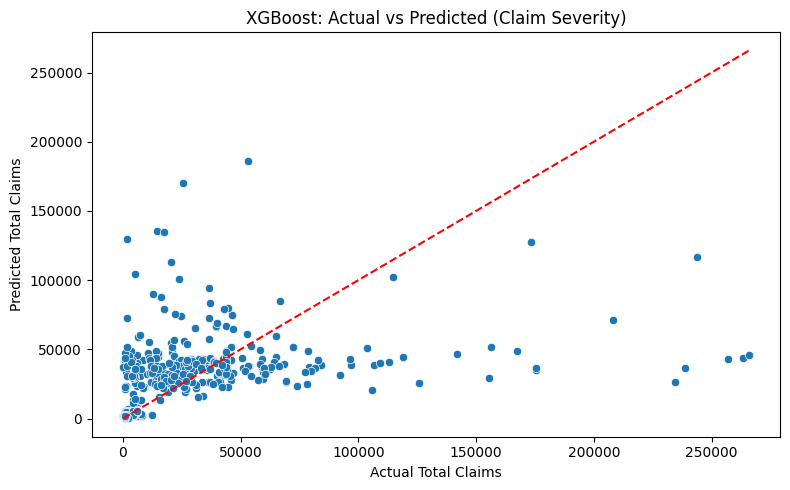

In [11]:
# # In[ ]: (New Cell)
# # Import necessary library if not already imported
# import xgboost as xgb

# # Initialize and train model
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=6,
#     random_state=42,
#     n_jobs=-1
# )

# xgb_model.fit(X_train_sev, y_train_sev)

# # Predict
# y_pred_xgb = xgb_model.predict(X_test_sev) # Changed variable name for clarity

# # Evaluation
# xgb_rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_xgb))
# xgb_r2 = r2_score(y_test_sev, y_pred_xgb)

# print(f"XGBoost Performance (Claim Severity):")
# print(f" RMSE: {xgb_rmse:.2f}")
# print(f" R² Score: {xgb_r2:.4f}")

# # Visualization
# plt.figure(figsize=(8, 5))
# sns.scatterplot(x=y_test_sev, y=y_pred_xgb)
# plt.xlabel("Actual Total Claims")
# plt.ylabel("Predicted Total Claims")
# plt.title("XGBoost: Actual vs Predicted (Claim Severity)")
# plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
# plt.tight_layout()
# plt.show()

### Model Interpretability (SHAP) for the Best Claim Severity Model

Interpreting the Random Forest model for Claim Severity...

Global Feature Importance (SHAP Bar Plot):


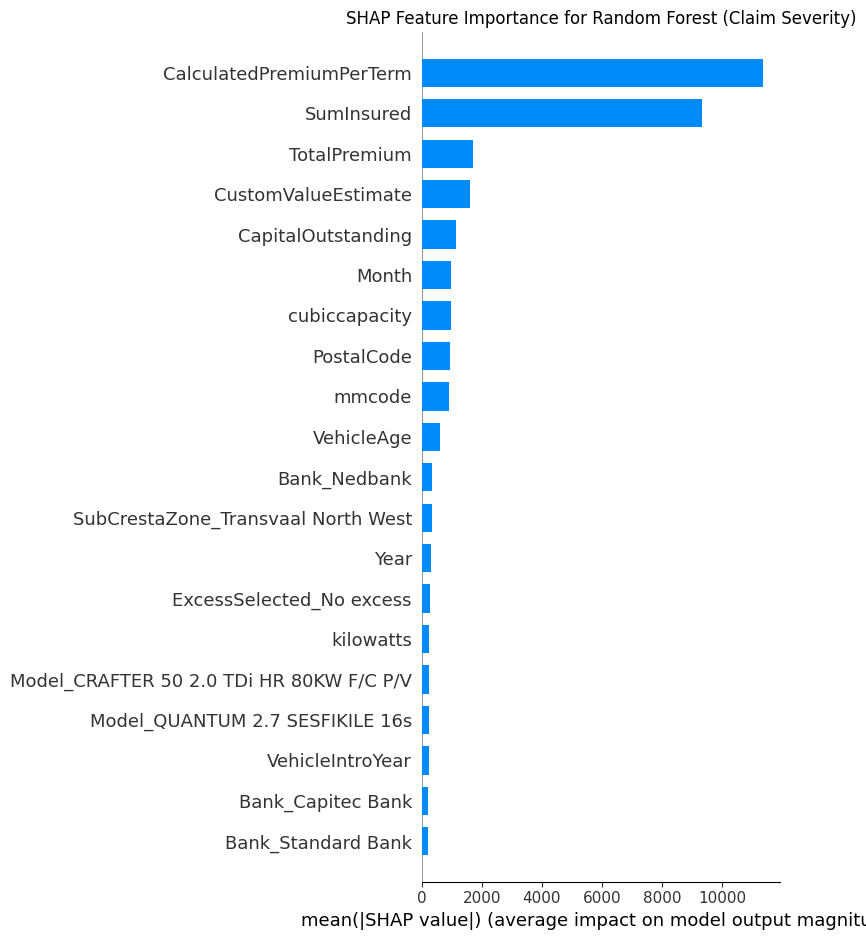


Top 10 Most Influential Features (Claim Severity):
                      feature  shap_abs_mean
17   CalculatedPremiumPerTerm   11351.334734
15                 SumInsured    9335.989601
18               TotalPremium    1713.549182
8         CustomValueEstimate    1605.936249
11         CapitalOutstanding    1144.271261
19                      Month     978.409527
5               cubiccapacity     972.462176
2                  PostalCode     943.869714
3                      mmcode     893.485733
264                VehicleAge     610.510097


In [42]:
import shap
best_severity_model = rf_model
best_severity_model_name = "Random Forest"
X_test_for_shap = X_test_sev # Use the test features for the best model

explainer = shap.TreeExplainer(best_severity_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

shap.summary_plot(shap_values, X_test_for_shap, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance for {best_severity_model_name} (Claim Severity)")
plt.tight_layout()
plt.show()

# Get top features for interpretation
shap_df = pd.DataFrame({
    'feature': X_test_for_shap.columns,
    'shap_abs_mean': np.abs(shap_values).mean(axis=0)
})
top_features = shap_df.sort_values(by='shap_abs_mean', ascending=False).head(10)
print("\nTop 10 Most Influential Features (Claim Severity):")
print(top_features)